# Setup

## Import packages

In [172]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from scipy.stats import zscore
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

In [2]:
def sns_joint_equal_axes(g):
    
    g.ax_joint.set_aspect('equal')
    
    # Get the position of the joint plot and marginal plots
    joint_position = g.ax_joint.get_position()
    xmarg_position = g.ax_marg_x.get_position()
    ymarg_position = g.ax_marg_y.get_position()

    # Set the position and size of the x-axis marginal plot
    g.ax_marg_x.set_position([xmarg_position.x0, joint_position.y1 + 0.02, joint_position.width, xmarg_position.height])

    # Set the position and size of the y-axis marginal plot
    g.ax_marg_y.set_position([ymarg_position.x0, joint_position.y0, ymarg_position.width, joint_position.height])
    
    return g


def pairwise_distances(df, target_ids, dimensions = ['soma_x', 'soma_y_adj', 'soma_z'], source_ids = None, source_coords = None):
    # Extract source coordinates
    if source_ids is not None:
        # source_ids is a tuple of ('column_name',[column_values])
        source_coords = df[df[source_ids[0]].isin(source_ids[1])].loc[:, dimensions].values
    
    # Extract target coordinates
    # target_ids is a tuple of ('column_name',[column_values])
    target_coords = df[df[target_ids[0]].isin(target_ids[1])].loc[:, dimensions].values

    # Handle NaN values
    source_coords = np.nan_to_num(source_coords, nan=np.nan)
    target_coords = np.nan_to_num(target_coords, nan=np.nan)

    # Calculate pairwise distances
    distances = np.linalg.norm(source_coords - target_coords, axis=-1)
    
    return distances

## Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [3]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

vx_sizes = [16,16,30]

# Molecular layer fit

In [4]:
from scipy.optimize import curve_fit 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

In [5]:
# Define mathematical function for curve fitting 
def func(xy, a, b, c, d, e, f, g, h):  # #h):#
    x, y = xy 
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x**3 + g*y**3 + h*x*y # + h*x*y #

In [6]:
Path(settings_dict['save_dir']).parent.parent

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome')

In [7]:
Path(settings_dict['save_dir']).parent.parent

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome')

In [8]:
neuroglancer_path = Path(settings_dict['save_dir']).parent.parent / 'blender/soma_locations/layer-molecular_annotation.json'
voxel_sizes = [16,16,30]
nl_ = 'molecular'

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)
    
neuroglancer_layer = next((item for item in neuroglancer_data['layers'] if item["name"] == nl_), None)
vertices = [[p['point'][i]*voxel_sizes[i] for i in range(3)] for p in neuroglancer_layer['annotations']]

x_pts = [p[0] for p in vertices]
y_pts = [p[1] for p in vertices]
z_pts = [p[2] for p in vertices]

In [150]:
np.median(y_pts)/16

16210.40625

In [9]:
# Perform curve fitting 
popt, pcov = curve_fit(func, (x_pts, z_pts), y_pts) 
  
# Print optimized parameters 
print(popt) 

[ 2.71956920e+05 -5.43115077e-02 -1.87026179e-01 -3.46153667e-07
  2.31048373e-06  9.59242290e-13 -1.51595014e-11  6.68290149e-07]Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



# Color Palette

In [10]:
syn_colors = {
    'sgx1':'#B2D732', #'#996633',
    'sgx2':'#FCCC1A',
    'sg1':'#B2D732',
    'sg2':'#FCCC1A',
    'grc':'#FEFE33',
    'smpl':'#8601AF',
    'dml':'#cccccc',
    'mg1':'#00CBFF',#'#347C98',#'#357D99',#'#80DBFF',##'#0000ff',
    'mg2':'#FB9902',#'#ff0000',
    'lf':'#FE2712',#'#8000c8',
    'lg':'#0247FE',#'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373',
    'pe':'#550055',
    'pf':'#880088',
    'mli':"000000",
    # 'uk':,
    # 'fov':,
    'h':'#666666'}


# Load files

## mg_network file names

In [44]:
dirpath = Path(settings_dict['save_dir'])


In [70]:
nodefiles = get_cell_filepaths(dirpath)

In [71]:
len(nodefiles)

5636

## df_syn pre or post

In [436]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn_pf.csv')
syn = 'post-synaptic'

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/graphs/df_postsyn_pf.csv'

In [ ]:
len(df_syn)

In [122]:
y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = func((r['x'], r['z']), *popt)
    y_adj = (r['y'] - yoffset)
    y_adj_col.append(y_adj)

df_syn.loc[:,'y_adj']=y_adj_col

for v in ['x','y','z','y_adj']:
    df_syn[v] = df_syn[v]/1000
df_syn['y_adj'] = df_syn['y_adj']*-1    

In [123]:
# pf_df = deepcopy(df_syn[(df_syn['pre_type'].isin(['pf']))&(df_syn['post_type'].isin(['mg1','mg2','lg','lf']))])
# pf_df['x']=pf_df['x'].apply(lambda x: x/16)
# pf_df['y']=pf_df['y'].apply(lambda x: x/16)
# pf_df['z']=pf_df['z'].apply(lambda x: x/30)

# pf_df.to_csv(Path('/Users/kperks/Downloads/pf_synapses.csv'))

# cell types for all files in directory

## from file

In [124]:
df_type = pd.read_csv(dirpath / 'metadata/df_type.csv')

## manual type

In [72]:
cell_type = {}
not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[int(x)]=np.NaN
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        
df_type = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])

df_type.loc[df_type['cell_type'].isin(['dml']),'cell_type']='mli'
df_type.loc[df_type['cell_type'].isin(['grc-d']),'cell_type']='grc'
df_type.loc[df_type['cell_type'].isin(['grc-s']),'cell_type']='smpl'
df_type.loc[df_type['cell_type'].isin(['pfm']),'cell_type']='pf'

the following cells are not typed in the main network
[]


## auto type

this field is populated when an auto-typing of the cells was different from the manual typing

In [73]:
cell_type = {}
# not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('auto') 
    if (cell.get_ctype('auto') == []) | (cell.get_ctype('auto') == ''):
        cell_type[int(x)]=np.NaN
        # not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
# print('the following cells are not typed in the main network')
# print(not_typed)        
        
df_type_auto = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])


In [74]:
df_type_auto.dropna(inplace=True)

In [75]:
df_type_auto.head()

,id,cell_type
99,127607174,mg2
101,127672247,mg2
149,129572524,mg1
732,213501262,mg1
757,214440956,mg2


## combine manual and auto df_type

In [76]:
for i,r in df_type_auto.iterrows():
    df_type.loc[i,'cell_type'] = r['cell_type'] # the match up of i for df_type and _auto depends on both being made by iterating over the same nodefiles list

In [25]:
df_type.head()

,id,cell_type
0,102463116,pf
1,103366246,uk
2,103549879,mli
3,109461049,fov
4,109502641,mli


In [43]:
df_type[df_type['cell_type'].isin(['pe'])]['id'].unique()

array([122750463, 123989376, 124050813, 124172071, 124237394, 125289067,
       125289233, 125332674, 125379175, 125487414, 126169118, 126276325,
       126403285, 126418610, 126570525, 127282095, 127576339, 183918283,
       189965873, 194562170, 196774802, 205964113, 206569656, 207354371,
       208918064, 210793819, 211145060, 211161121, 211162106, 211162988,
       211347052, 211365273, 212291135, 212292324, 212307194, 212307548,
       212522501, 213144996, 213716213, 214349726, 214691209,  23379765,
       262719475, 285761792, 292428845, 295969408,  29630928, 297083216,
       297240507, 297240553, 298245632, 298307530, 298368158, 299065177,
       299312130, 299576347, 299577008, 300225084, 300225655, 302809903,
        30497561,  31781654,  32745134,  32802856,  33530146,  34210974,
        34724672,  35018909,  35943945,  36145073,  36253444,  36918870,
        36996793,  37074974,  37244312,  37274486,  37337694,  37340375,
       377406579,  38004222,  38326704,  38329784, 

## save to file

In [77]:
df_type.to_csv(dirpath / 'metadata/df_type.csv')

In [52]:
df_type['cell_type'].isin(['dml']).sum()

0

# add cell type to df_syn

In [125]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

In [126]:
# include only connections to the following types/groups of cells
included_groups = ['mli']#['sg1','sg2','mg1','mg2','lg','lf','tsd','h','mli']#,'dml']
df_syn = df_syn[(df_syn['pre_type'].isin(included_groups))]#& df_syn['pre_type'].isin(['mg1','mg2'])]
len(df_syn)

999

# shuffle df_syn

In [935]:
df_syn_rand = deepcopy(df_syn)

shuff_rows = df_syn_rand[['pre','pre_type']].sample(frac = 1)
df_syn_rand.loc[:,['pre']] = shuff_rows['pre'].values
df_syn_rand.loc[:,['pre_type']] = shuff_rows['pre_type'].values

df_syn = df_syn_rand

# --> df_edges

In [58]:
df_syn.head()

,Unnamed: 0,pre,post,structure,x,y,z,y_adj,pre_type,post_type
0,0,126618353,303212610,basal dendrite,369.840,314.688,52.26,-54.350501,mg1,mg2
1,1,126618353,387850816,basal dendrite,369.584,313.776,52.26,-53.468711,mg1,mg2
2,2,126618353,303212610,basal dendrite,368.736,314.784,52.56,-54.523112,mg1,mg2
3,3,126618353,394686712,unknown,370.112,314.832,52.62,-54.398373,mg1,lf
4,4,126618353,396961287,apical dendrite,369.152,313.424,52.44,-53.135626,mg1,uk


In [937]:
# remove structure and soma diameter information if want to
# df_syn = df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1)#,'pre_diam','post_diam','diam_diff'],axis=1) # 

In [127]:
df_edges=df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

In [61]:
df_edges[df_edges['pre_type'].isin(['pe'])]['pre'].unique()

array([386579108, 530044972, 638373058, 642782594, 630355985, 183918283,
       295969408, 285761792])

In [118]:
df_edges['pre'].unique()

array([365756203, 457217192, 290280494, 473274862, 383050900, 559257305,
       368107256, 385234105])

# synapses locations in df_syn

## absolute

In [128]:
df_syn['depth'] = pd.cut(df_syn['y_adj'], bins=np.arange(0,350,50))

In [129]:
df_syn.head()

,Unnamed: 0,pre,post,structure,x,y,z,y_adj,pre_type,post_type,depth
0,0,290280494,644005141,apical dendrite,241.616,200.512,88.77,56.978643,mli,mg1,"(50, 100]"
1,1,290280494,305130656,apical dendrite,240.720,199.760,87.90,57.702151,mli,tsd,"(50, 100]"
2,2,290280494,54299262,apical dendrite,239.504,203.248,84.60,54.099486,mli,h,"(50, 100]"
3,3,290280494,482479436,apical dendrite,237.632,207.824,81.06,49.371557,mli,h,"(0, 50]"
4,4,290280494,473353228,apical dendrite,237.872,206.976,81.15,50.223340,mli,sg1,"(50, 100]"


In [130]:
mask = df_syn['post_type'].isin(['sg1','sg2','mg1','mg2','lg','lf','smpl','mli','tsd','h'])# df_edges['pre'].isin([295969348,295969442,295969134,295969355,295968777,282228761,283375247,283391297,283390956,282230475,268614458,268614383,273086215,187230424,290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336,117041378,122039969,36165549]) &  

In [131]:
df_grouped = df_syn[mask][['pre','post_type','depth']].groupby(['depth','post_type'],observed=False).count().reset_index()

In [132]:
df_grouped.head()#[df_grouped['weight']>0]

,depth,post_type,pre
0,"(0, 50]",h,29
1,"(0, 50]",lf,28
2,"(0, 50]",lg,36
3,"(0, 50]",mg1,49
4,"(0, 50]",mg2,65


In [133]:
df_grouped.loc[df_grouped['post_type'].isin(['sg1','sg2']),'class'] = 'sg'
df_grouped.loc[df_grouped['post_type'].isin(['mg1','mg2']),'class'] = 'mg'
df_grouped.loc[df_grouped['post_type'].isin(['lf','lg']),'class'] = 'output'
df_grouped.loc[df_grouped['post_type'].isin(['smpl','mli','tsd','h']),'class'] = 'smooth'

In [134]:
df_grouped['weight_norm'] = df_grouped.groupby('depth',observed=False)['pre'].transform(lambda x: (x / x.sum()) )

df_grouped['weight_all'] = df_grouped.groupby('depth',observed=False)['pre'].transform(lambda x: (x.sum()) )


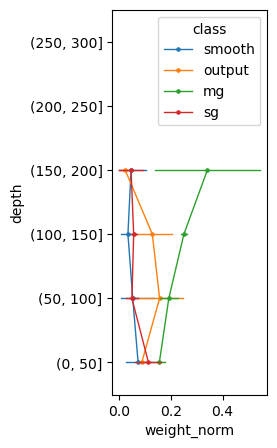

In [135]:
# Create a seaborn plot
hfig,ax = plt.subplots(1,figsize=(2,5))
sns.pointplot(data=df_grouped,y='depth', x='weight_norm',hue = 'class',linewidth=1)#,order = ['lg','mg1','sg1','lf','mg2','sg2'])
ax.invert_yaxis()
plt.savefig('/Users/kperks/Downloads/PFsynapse_locations_binned_normalized.svg',transparent=True) 

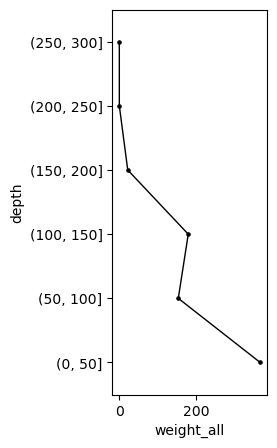

In [136]:
# sns.pointplot(data=df_grouped,x='depth', y='weight_all',color='black')
hfig,ax = plt.subplots(1,figsize=(2,5))
sns.pointplot(data=df_grouped,y='depth', x='weight_all',color='black',linewidth=1)#,order = ['lg','mg1','sg1','lf','mg2','sg2'])
ax.invert_yaxis()
plt.savefig('/Users/kperks/Downloads/PFsynapse_locations_binned_TOTAL.svg',transparent=True) 

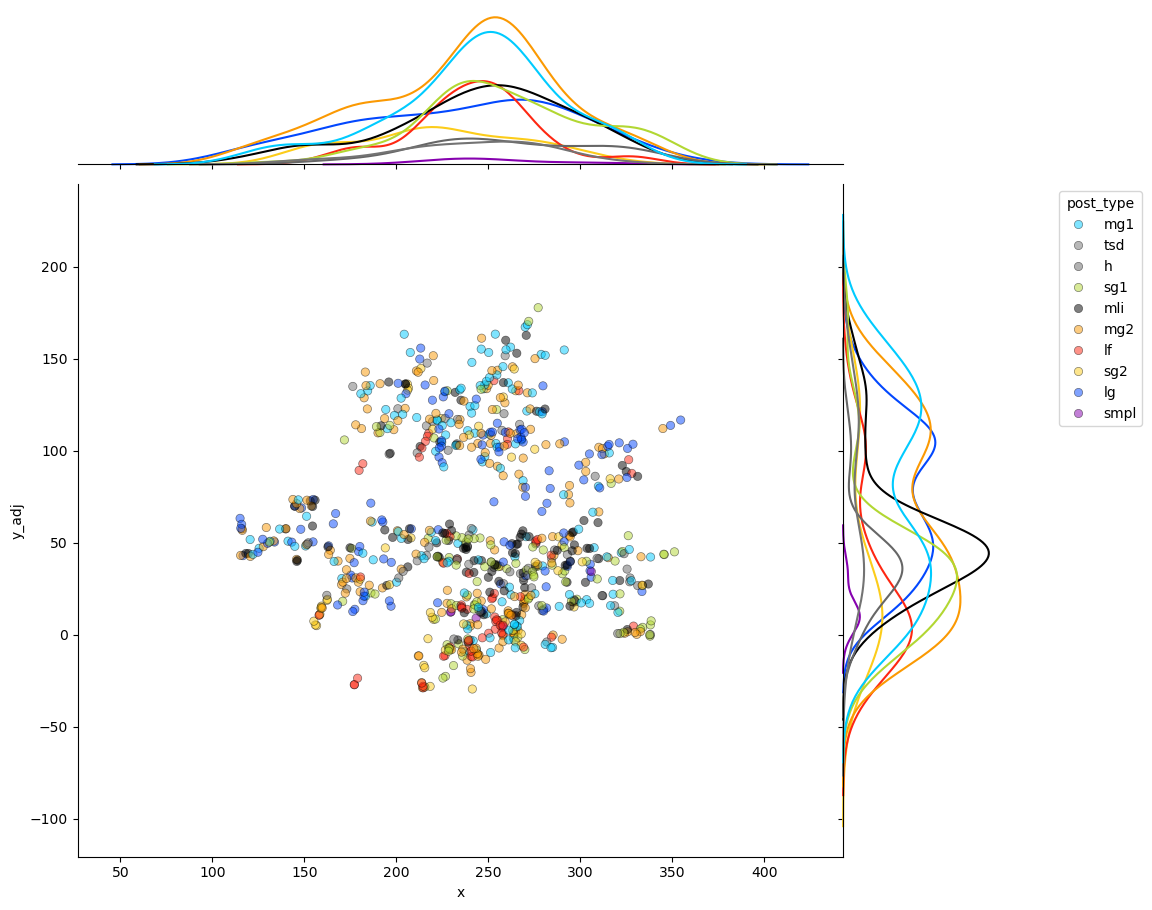

In [137]:

g = sns.jointplot(data=df_syn[df_syn['post_type'].isin(['mg2','mg1','sg2','sg1','lg','lf','smpl','mli','tsd','h'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y_adj", hue="post_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

# g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['mg2','mg1'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
#                   x="x", y="z", hue="pre_type", height=10,
#                   alpha = 0.5, edgecolor='black',palette = syn_colors,
#                  marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# # sns.scatterplot(x=[0],y=[0],color='black',s=100);

# sns_joint_equal_axes(g);
# sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

# Connection patterns

In [138]:
count_type = 'nsyn' # 'ncells' #
mask = (df_edges['post_type'].isin(['sg1','sg2','mg1','mg2','lg','lf','smpl','mli','tsd','h'])) # df_edges['pre'].isin([290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336,117041378,122039969,36165549]) & 
#[295969348,295969442,295969134,295969355,295968777,282228761,283375247, 283391297,283390956,282230475,268614458,268614383,273086215,187230424]

types_ = ['mli'] #should be all that is in df_pfsyn anyway
df_map = pd.DataFrame()
for t in types_:
    if count_type == 'nsyn':
        df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
            ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
            index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    if count_type == 'ncells':
        df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
            ['pre','pre_type','post_type']).count().reset_index().pivot(
            index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
df_map = df_map.fillna(0)
df_map = df_map.set_index('pre')
df_map = df_map.drop(['pre_type'],axis=1)

In [139]:
df_map#.head()

post_type,h,lf,lg,mg1,mg2,mli,sg1,sg2,smpl,tsd
pre,,,,,,,,,,
290280494,23.0,14.0,6.0,18.0,25.0,30.0,36.0,3.0,0.0,11.0
356567071,2.0,10.0,1.0,15.0,11.0,6.0,4.0,4.0,0.0,12.0
365756203,1.0,0.0,23.0,41.0,25.0,10.0,6.0,7.0,0.0,0.0
368107256,0.0,0.0,31.0,7.0,23.0,0.0,0.0,3.0,0.0,0.0
383050900,4.0,1.0,15.0,24.0,18.0,31.0,26.0,5.0,1.0,2.0
385234105,0.0,20.0,0.0,13.0,20.0,5.0,12.0,8.0,4.0,1.0
457217192,3.0,1.0,35.0,17.0,31.0,18.0,3.0,1.0,0.0,2.0
473274862,1.0,7.0,1.0,2.0,7.0,0.0,0.0,11.0,0.0,0.0
559257305,2.0,14.0,0.0,3.0,12.0,2.0,10.0,7.0,0.0,0.0


## connectivity heatmap

In [140]:
target_order = ['lg','mg1','sg1','lf','mg2','sg2','smpl','mli','h','tsd']
df_map = df_map.loc[:,[t for t in target_order if t in df_map.columns.values]]

In [141]:
df_map.sum()

post_type
lg      112.0
mg1     140.0
sg1      97.0
lf       67.0
mg2     172.0
sg2      49.0
smpl      5.0
mli     102.0
h        36.0
tsd      28.0
dtype: float64

[]

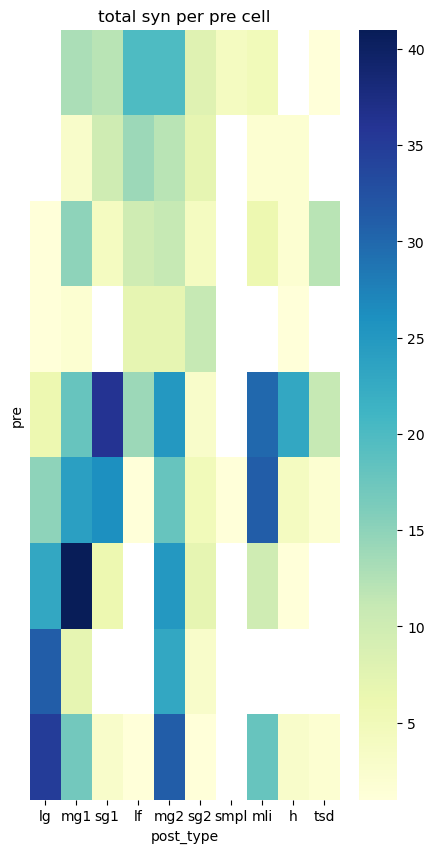

In [142]:
cmap = sns.color_palette("YlGnBu", as_cmap=True)  # Base colormap
cmap.set_under('white')  # Set color for values below the colormap's minimum (i.e., 0)

# Ensure all 0s are treated as "under" the colormap range
# df_map = df_map.replace(0, -1)  # Replace 0s with a value below the colormap range

# fig, axes = plt.subplots(1, figsize=(5,10))
# sns.heatmap(data=df_map.sort_values(['lg']), annot=False, fmt="0.0f", cmap="YlGnBu", ax=axes)#  .sort_index()
# # sns.heatmap(data=df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])
# axes.set_title('total syn per pre cell')

# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=df_map.sort_values(['lg']), annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per pre cell')
axes.set_yticks([])

In [143]:
sort1 = 'mg1'
sort1_map = df_map[df_map[sort1]>0].sort_values([sort1],ascending=False)

In [144]:
sort2 = 'mg2'
sort2_map = df_map[~df_map.index.isin(sort1_map.index)].sort_values([sort2])

In [145]:
other_map = df_map[(~df_map.index.isin(sort1_map.index)) & ~df_map.index.isin(sort2_map.index)]#.sort_values(['mg2'],ascending=False)

In [146]:
sorted_full = pd.concat([sort1_map,other_map,sort2_map])

[]

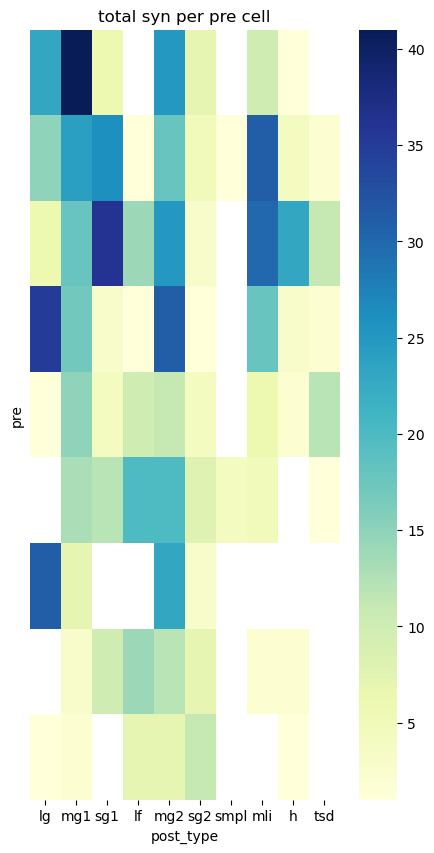

In [147]:
# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=sorted_full, annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per pre cell')
axes.set_yticks([])

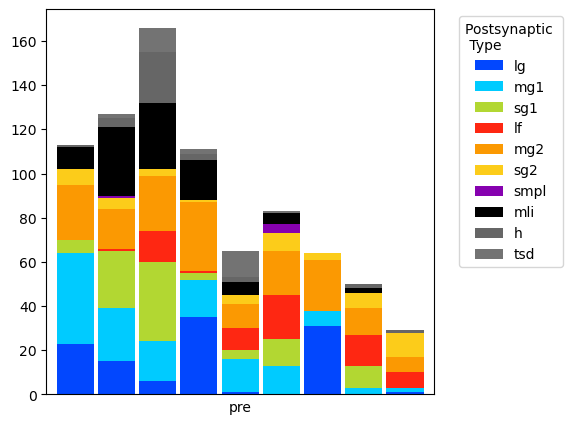

In [148]:
# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
# Create a stacked bar plot
sorted_full.loc[:,target_order].plot.bar(stacked=True,color = syn_colors,ax=ax, width=0.9)
ax.set_xticks([])
ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.35, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/mli_output_stacked_bar.svg', format='svg', transparent=True)

# KC fig 4 analysis

In [862]:
def get_p_connect(df_edges,mask,count_type):

# count_type = 'nsyn' # 'ncells' #
# mask = (df_edges['post_type'].isin(['sg1','sg2','mg1','mg2','lg','lf']))#,'mli','tsd','dml'])) # df_edges['pre'].isin([290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336,117041378,122039969,36165549]) & 
#[295969348,295969442,295969134,295969355,295968777,282228761,283375247, 283391297,283390956,282230475,268614458,268614383,273086215,187230424]

    types_ = ['pf'] #['mg1','mg2']#should be all that is in df_pfsyn anyway
    df_map = pd.DataFrame()
    for t in types_:
        if count_type == 'nsyn':
            df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
                ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
                index='pre', columns='post_type', values='weight').fillna(0).reset_index()
        
        if count_type == 'ncells':
            df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
                ['pre','pre_type','post_type']).count().reset_index().pivot(
                index='pre', columns='post_type', values='post').fillna(0).reset_index()
        
        df_grouped['pre_type']=t
        df_map = pd.concat([df_map,df_grouped])
        
    df_map = df_map.fillna(0)
    df_map = df_map.set_index('pre')
    df_map = df_map.drop(['pre_type'],axis=1)
    
    
    df_norm = df_map.div(df_map.sum(axis=1),axis=0)#.mul(100).round(0)

    return df_norm
# sns.heatmap(data=df_norm.sort_values('lcf'), annot=True, fmt="0.0f", cmap="YlGnBu")

## data

In [911]:
df_syn = pd.read_csv(dirpath / 'graphs/df_pfsyn.csv')
syn = 'post-synaptic'

In [912]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

In [913]:
# include only connections to the following types/groups of cells
included_groups = ['lg','mg1','sg1','lf','mg2','sg2']
df_syn = df_syn[(df_syn['post_type'].isin(included_groups))]#& df_syn['pre_type'].isin(['mg1','mg2'])]
len(df_syn)

490

In [914]:
df_syn['pre'].nunique()

60

In [915]:
df_syn.head()

,Unnamed: 0,pre,post,structure,x,y,z,pre_type,post_type
3,3,117041378,42644625,apical dendrite,115503,196503,19515,pf,sg1
4,4,117041378,214411806,apical dendrite,152435,195162,31365,pf,mg1
5,5,117041378,214411806,apical dendrite,151155,195042,30975,pf,mg1
6,6,117041378,301510112,apical dendrite,175499,195996,38565,pf,sg2
7,7,117041378,301510112,apical dendrite,174227,195700,37875,pf,sg2


## shuffle df_syn

In [916]:
df_syn_rand = deepcopy(df_syn)

## connection probability by cell type

In [929]:
count_type = 'nsyn'
by_group='lf'

### data

In [930]:
df_edges=df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

mask = (df_edges['post_type'].isin(included_groups))

df_norm_data = get_p_connect(df_edges,mask,count_type)

result_data = df_norm_data[(df_norm_data[by_group] != 0)].mean()

### shuffle result

In [931]:
result_df = pd.DataFrame()

# Iterate the specified number of times
for i in range(100):
    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_rand[['pre','pre_type']].sample(frac = 1)
    df_syn_rand.loc[:,['pre']] = shuff_rows['pre'].values
    df_syn_rand.loc[:,['pre_type']] = shuff_rows['pre_type'].values

    df_edges=df_syn_rand.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')
    mask = (df_edges['post_type'].isin(included_groups))

    df_norm = get_p_connect(df_edges,mask,count_type)
    
    # Compute the mean for rows where 'mg2' is not zero
    mean_row = df_norm[(df_norm[by_group] != 0)].mean(numeric_only=True) #df_shuffled[df_shuffled[by_group] != 0].mean(numeric_only=True)
    
    # Append the result as a row to the result_df
    result_df = pd.concat([result_df, pd.DataFrame([mean_row])], ignore_index=True)

### plot comparison

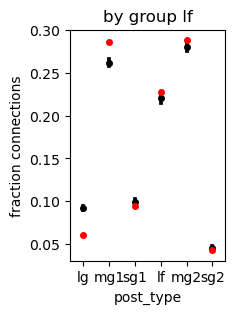

In [932]:
hfig,ax = plt.subplots(1,figsize=(2,3))

# plot single iteration, individual cells
# sns.pointplot(data = df_norm,linestyle='',color = 'black',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'],errorbar='sd')
# sns.pointplot(data=df_norm_data[(df_norm_data[by_group] != 0)],linestyle='',color = 'red',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'],errorbar='sd')

# plot iteration means
sns.pointplot(data = result_df,linestyle='',color = 'black',markersize = 3,order = included_groups,errorbar=('ci'))
sns.pointplot(data=result_data,linestyle='',color = 'red',markersize = 3,order = included_groups)

ax.set_ylabel('fraction connections')
ax.set_title(f'by group {by_group}')

plt.savefig(f'/Users/kperks/Downloads/pf_output_conditionalP_{by_group}.svg', format='svg', transparent=True)

# Patterns of connectivity (PCA)

In [958]:
def calculate_percent_total(row):
    total = row.sum()
    if total == 0:
        return row  # If total is 0, return the row as is (unchanged)
    else:
        return row / total  # Normalize by dividing each element by the total
#row / total 

In [962]:
df_syn = pd.read_csv(dirpath / 'graphs/df_pfsyn.csv')
syn = 'post-synaptic'

In [963]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

In [965]:
# include only connections to the following types/groups of cells
included_groups = ['sg1','sg2','mg1','mg2','lg','lf']
df_syn = df_syn[(df_syn['post_type'].isin(included_groups))] #]#
len(df_syn)

490

## shuffle df_syn

In [966]:
df_syn_rand = deepcopy(df_syn)

## params of analysis

In [967]:
# post-synaptic labeling
dsource = 'pre_type'
idsource = 'pre'
dtarget = 'post_type'

# Desired pre_types and order
source_types_order = ['pf']#
# Desired post_types order
target_types_order =  ['sg1', 'mg1','lg', 'sg2','mg2','lf'] #['aff',  'sg1','mg1', 'grc', 'sg2','mg2']

## data

In [979]:
df_edges=df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

# Filter out rows with post_type not in post_types_order
df_edges_filtered = df_edges[df_edges[dsource].isin(source_types_order)]

# Pivot table to get sum of weights per post and pre_type
pivot_df = df_edges_filtered.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)

# Reindex columns to include only the specified pre_types in the desired order
pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)

# Reset index to turn 'post' and 'post_type' from index to columns
pivot_df.reset_index(inplace=True)

# Sort the dataframe based on post_type
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)
pivot_df.set_index(idsource, inplace=True)

# Apply the function to each row
# norm_df = pivot_df.drop(columns=dsource).apply(calculate_percent_total, axis=1)
norm_df = pivot_df.select_dtypes(include='number').apply(calculate_percent_total, axis=1)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(norm_df)

# Perform PCA
npc = 6
pca = PCA(n_components=npc)  # You can change the number of components as needed

pca_result = pca.fit_transform(scaled_data)

# get loadings of dimensions onto each principal component
loadings = pca.components_.T

# Add PCA results to the DataFrame
for i in range(npc):
    pivot_df[str(i)] = pca_result[:, i]

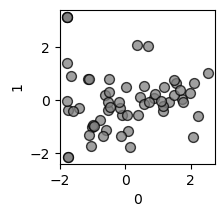

In [980]:
hfig,ax = plt.subplots(1,figsize=(2,2))
sns.scatterplot(ax=ax,data=pivot_df,x='0',y='1',linewidth=1,color='gray',edgecolor='black',s=50,alpha = 0.75)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.show()
plt.savefig(f'/Users/kperks/Downloads/pf_pca.svg', format='svg', transparent=True)

In [981]:
result_data = pd.DataFrame(pca.explained_variance_ratio_.reshape(1, -1),columns=range(len(pca.explained_variance_ratio_)))

### shuffle result

In [982]:
result_df = pd.DataFrame()

# Iterate the specified number of times
for i in range(50):
    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_rand[['pre','pre_type']].sample(frac = 1)
    df_syn_rand.loc[:,['pre']] = shuff_rows['pre'].values
    df_syn_rand.loc[:,['pre_type']] = shuff_rows['pre_type'].values
    
    df_edges=df_syn_rand.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')
    # Filter out rows with post_type not in post_types_order
    df_edges_filtered = df_edges[df_edges[dsource].isin(source_types_order)]
    
    # Pivot table to get sum of weights per post and pre_type
    pivot_df = df_edges_filtered.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)
    
    # Reindex columns to include only the specified pre_types in the desired order
    pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)
    
    # Reset index to turn 'post' and 'post_type' from index to columns
    pivot_df.reset_index(inplace=True)
    
    # Sort the dataframe based on post_type
    pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
    pivot_df.sort_values(dsource, inplace=True)
    pivot_df.set_index(idsource, inplace=True)
    
    # Apply the function to each row
    # norm_df = pivot_df.drop(columns=dsource).apply(calculate_percent_total, axis=1)
    norm_df = pivot_df.select_dtypes(include='number').apply(calculate_percent_total, axis=1)
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(norm_df)
    
    # Perform PCA
    npc = 6
    pca = PCA(n_components=npc)  # You can change the number of components as needed
    pca_result = pca.fit_transform(scaled_data)

        # get loadings of dimensions onto each principal component
    loadings = pca.components_.T
    
    # Add PCA results to the DataFrame
    for i in range(npc):
        pivot_df[str(i)] = pca_result[:, i]
    
    # Append the result as a row to the result_df
    result_df = pd.concat([result_df, pd.DataFrame(pca.explained_variance_ratio_.reshape(1, -1))], ignore_index=True)

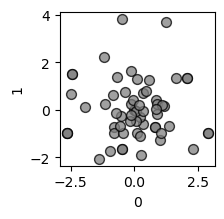

In [984]:
hfig,ax = plt.subplots(1,figsize=(2,2))
sns.scatterplot(ax=ax,data=pivot_df,x='0',y='1',linewidth=1,color='gray',edgecolor='black',s=50,alpha = 0.75)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.show()
plt.savefig(f'/Users/kperks/Downloads/pf_pca_shuffle.svg', format='svg', transparent=True)

### plot comparison

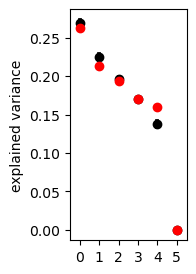

In [985]:
hfig,ax = plt.subplots(1,figsize=(1.5,3))

# plot single iteration, individual cells
# sns.pointplot(data = df_norm,linestyle='',color = 'black',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'])
# sns.pointplot(data=df_norm_data[(df_norm_data[by_group] != 0)],linestyle='',color = 'red',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'])

# plot iteration means
sns.pointplot(data = result_df,linestyle='',color = 'black',markersize = 5,errorbar='ci')
sns.pointplot(data=result_data,linestyle='',color = 'red',markersize = 5)

ax.set_ylabel('explained variance')
plt.savefig(f'/Users/kperks/Downloads/pf_output_pca_compare.svg', format='svg', transparent=True)

# mli presynaptic

## df_syn pre or post

In [14]:
df_syn = pd.read_csv(dirpath / 'graphs/df_presyn_mli.csv')
syn = 'pre-synaptic'

In [15]:
len(df_syn)

56

In [16]:
df_syn = df_syn.rename(columns={'pre':'post','post':'pre','pre_type':'post_type','post_type':'pre_type'})
# df_syn

In [17]:
y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = func((r['x'], r['z']), *popt)
    y_adj = (r['y'] - yoffset)
    y_adj_col.append(y_adj)

df_syn.loc[:,'y_adj']=y_adj_col

for v in ['x','y','z','y_adj']:
    df_syn[v] = df_syn[v]/1000
df_syn['y_adj'] = df_syn['y_adj']*-1    

## add cell type to df_syn

In [32]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'], r['post'])
    continue

    # try:
    #     df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    # except:
    #     print(r['post'])
    # continue


# df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
# df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

In [34]:
# df_syn

In [41]:
df_syn[df_syn['post'].isin([365756203])]['pre'].unique()

array([617719313,  18846264, 364607097, 451709676, 364609388, 180406951,
       363462525, 363463160, 279896109])

## --> df_edges

In [151]:
df_syn.head()

,Unnamed: 0,post,pre,structure,x,y,z,y_adj,pre_type,post_type
0,0,290280494,466619967,axon,275.717,208.804,53.715,46.137768,mli,mli
1,1,368107256,216950312,unknown,272.480,156.640,62.520,99.241895,uk,mli
2,2,368107256,368151126,unknown,283.360,154.544,58.710,101.087592,pf,mli
3,3,383050900,30497561,unknown,285.924,244.611,56.204,10.775279,pe,mli
4,4,383050900,302950770,axon,282.053,243.915,55.005,11.257530,smpl,mli


In [152]:
# remove structure and soma diameter information if want to
# df_syn = df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1)#,'pre_diam','post_diam','diam_diff'],axis=1) # 

In [35]:
df_edges=df_syn.drop(['Unnamed: 0','x','y','z','y_adj','structure'],axis=1).value_counts().reset_index(name='weight')

## Connection patterns

In [36]:
count_type = 'nsyn' # 'ncells' #
mask = (df_edges['pre_type'].isin(df_edges['pre_type'].unique()))#['aff','grc','smpl','sg1','sg2','mli','tsd','dml'])) # df_edges['pre'].isin([290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336,117041378,122039969,36165549]) & 
#[295969348,295969442,295969134,295969355,295968777,282228761,283375247, 283391297,283390956,282230475,268614458,268614383,273086215,187230424]

types_ = ['mli']#, 
df_map = pd.DataFrame()
for t in types_:
    if count_type == 'nsyn':
        df_grouped = df_edges[(df_edges['post_type']==t) & mask].groupby(
            ['post','post_type','pre_type']).sum(numeric_only=True).reset_index().pivot(
            index='post', columns='pre_type', values='weight').fillna(0).reset_index()
    
    if count_type == 'ncells':
        df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
            ['pre','pre_type','post_type']).count().reset_index().pivot(
            index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['post_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
df_map = df_map.fillna(0)
df_map = df_map.set_index('post')
df_map = df_map.drop(['post_type'],axis=1)

In [37]:
df_map.head()

pre_type,fov,grc,mli,pe,pf,sgx2,smpl,uk
post,,,,,,,,
290280494,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
365756203,3.0,0.0,0.0,0.0,6.0,0.0,0.0,2.0
368107256,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
383050900,0.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0
385234105,0.0,1.0,2.0,12.0,0.0,1.0,0.0,20.0


### connectivity heatmap

[]

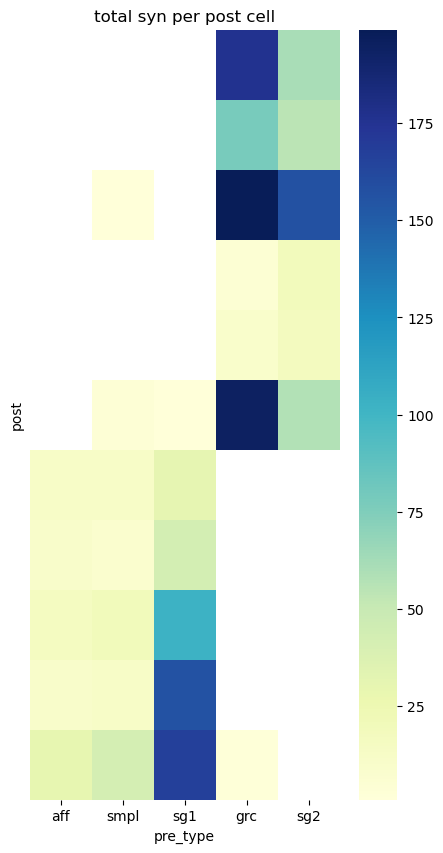

In [110]:
target_order = ['aff','smpl','sg1','grc','sg2']#['lg','mg1','lf','mg2']#['lg','mg1','sg1','lf','mg2','sg2']#
df_map = df_map.loc[:,[t for t in target_order if t in df_map.columns.values]]

cmap = sns.color_palette("YlGnBu", as_cmap=True)  # Base colormap
cmap.set_under('white')  # Set color for values below the colormap's minimum (i.e., 0)

# Ensure all 0s are treated as "under" the colormap range
# df_map = df_map.replace(0, -1)  # Replace 0s with a value below the colormap range


# fig, axes = plt.subplots(1, figsize=(5,10))
# sns.heatmap(data=df_map.sort_values(['lg']), annot=False, fmt="0.0f", cmap="YlGnBu", ax=axes)#  .sort_index()
# # sns.heatmap(data=df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])
# axes.set_title('total syn per pre cell')




# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=df_map.sort_values(['sg1']), annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per post cell')
axes.set_yticks([])



In [111]:
sg1_map = df_map[df_map['sg1']>1].sort_values(['sg1'])

In [112]:
sg2_map = df_map[~df_map.index.isin(sg1_map.index)].sort_values(['sg2'],ascending=False)

In [113]:
sorted_full = pd.concat([sg2_map,sg1_map])

[]

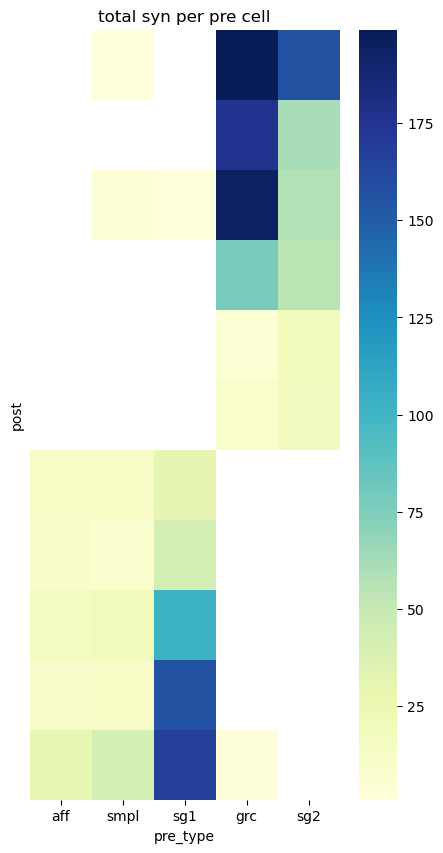

In [114]:
# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=sorted_full, annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per pre cell')
axes.set_yticks([])

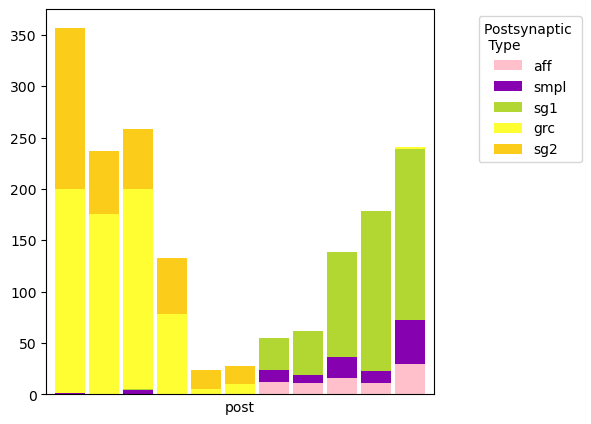

In [115]:
# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
# Create a stacked bar plot
sorted_full.loc[:,target_order].plot.bar(stacked=True,color = syn_colors,ax=ax, width=0.9)
ax.set_xticks([])
ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.4, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/output_stacked_bar_presyn.svg', format='svg', transparent=True)

In [221]:
df_norm = df_map.div(df_map.sum(axis=1),axis=0).mul(100)#.round(0)

In [222]:
sg1_map = df_norm[df_norm['sg1']>1].sort_values(['sg1'])

sg2_map = df_norm[~df_norm.index.isin(sg1_map.index)].sort_values(['sg2'],ascending=False)

norm_sorted_full = pd.concat([sg2_map,sg1_map])

[]

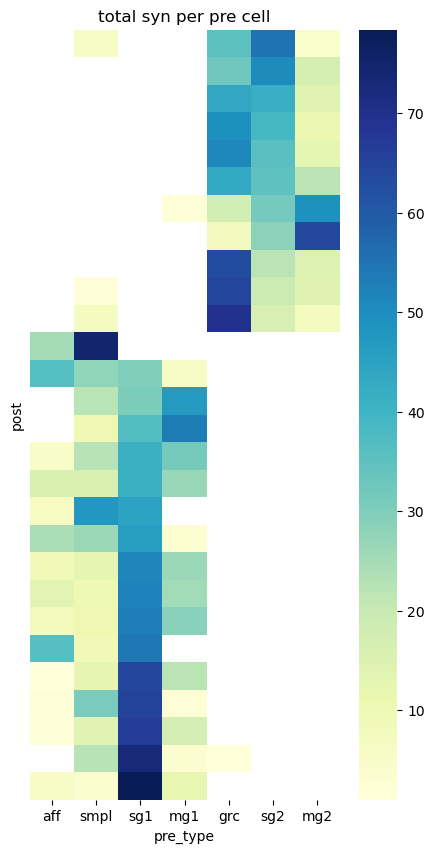

In [223]:
# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=norm_sorted_full, annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per pre cell')
axes.set_yticks([])

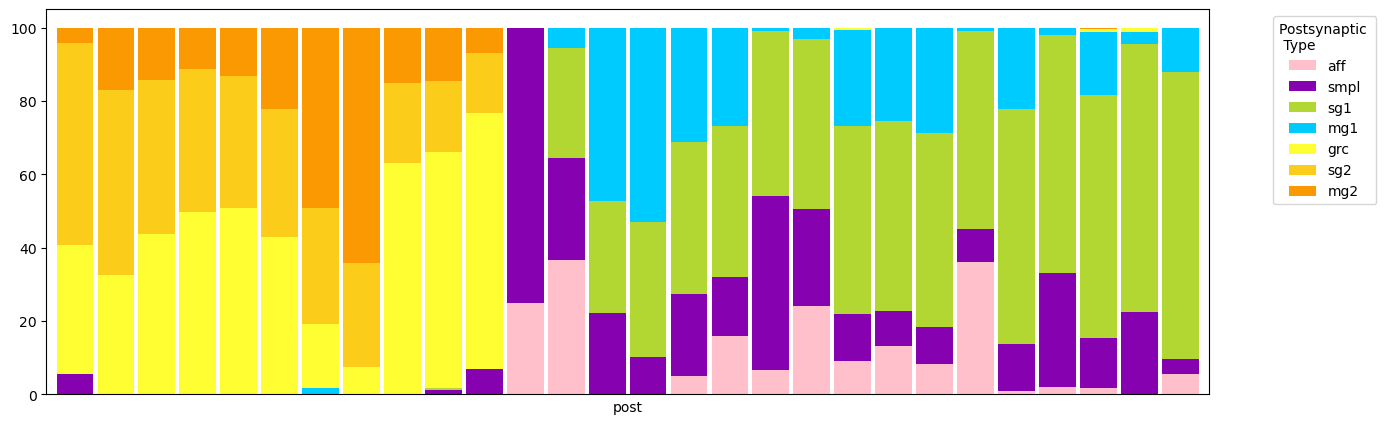

In [224]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
# Create a stacked bar plot
norm_sorted_full.loc[:,target_order].plot.bar(stacked=True,color = syn_colors,ax=ax, width=0.9)
ax.set_xticks([])
ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/mg_output_stacked_bar_presyn_normalized.svg', format='svg', transparent=True)

# Spine Counts


## spine density estimates

In [189]:
directory_path_mark = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/Spine_Density_Annotation/from_mark')

In [374]:
cell_filepaths_mark = get_cell_filepaths(directory_path_mark) # gets filepaths for all cells in a directory"
cell_filepaths_mg_network = get_cell_filepaths(Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network')) # gets filepaths for all cells in a directory"

In [193]:
cellids = list(cell_filepaths.keys())

In [194]:
cellids

['128737253',
 '214581797',
 '299249397',
 '299496636',
 '300474334',
 '301787806',
 '307418797',
 '386117124',
 '386224676',
 '393325331',
 '394115741',
 '472392041']

In [209]:
df_type[df_type['id'].isin([int('128737253')])]['cell_type'].values[0] in ['lg','lf']

False

In [330]:
[c for c in cellids if df_type[df_type['id'].isin([int(c)])]['cell_type'].values[0] in ['lg','lf']] #['mg1','mg2']]


['300474334', '301787806', '307418797', '393325331', '394115741', '472392041']

In [ ]:
id_ = '128737253'
cell = ecrest(settings_dict,filepath = cell_filepaths_main[id_], launch_viewer=True)

In [426]:
anno_loc = 'spineD loc'
anno_pts = 'spineD pts'
vx_sizes = [16, 16, 30]
'''assumes that the annotation is a point annotation stored in the list as ([x,y,z,segment_id],'annotatePoint')
                previous ot Jan 25 2024, it was just [x,y,z,segment_id]'''

data = []

for id_ in cellids: #[c for c in cellids if df_type[df_type['id'].isin([int(c)])]['cell_type'].values[0] in ['mg1','mg2']]:# ['lg','lf']]: #
    # id_ = cellids[0]
    
    # open cell from mg_network for cell type because got deleted from some of Marks files?
    cell = ecrest(settings_dict,filepath = cell_filepaths_mg_network[id_],launch_viewer=False)
    ctype = cell.get_ctype("manual")
    
    # open cell from mark's folder to get spine annotation data
    cell = ecrest(settings_dict,filepath = cell_filepaths[id_],launch_viewer=False)
        
    for loc_ in cell.cell_data['end_points'][anno_loc]:
        x,y,z = [p for p in loc_[0]]     
        y = -(y/16 - 16210)
        x = x/16
        z = z/30
    
        d = [np.linalg.norm(np.array(pt_[0]) - np.array(loc_[0])) for pt_ in cell.cell_data['end_points'][anno_pts] if (np.linalg.norm(np.array(pt_[0]) - np.array(loc_[0])))<5100]
        
        data.append({'id': id_, 'cell_type': ctype[0], 'x': x, 'y': y, 'z': z, 'n': len(d)})#, ignore_index=True)

df = pd.DataFrame(data)

In [427]:
df.sort_values('x')

,id,cell_type,x,y,z,n
171,386117124,m,4566.0,5794.0,2693.0,114
174,386117124,m,4710.0,9059.0,1559.0,96
172,386117124,m,4797.0,7264.0,2595.0,156
173,386117124,m,4810.0,8586.0,2249.0,97
170,386117124,m,4993.0,4312.0,2653.0,111
...,...,...,...,...,...,...
81,299496636,m,23252.0,10508.0,3257.0,0
43,214581797,m,24818.0,11889.0,1470.0,67
44,214581797,m,26042.0,12166.0,1380.0,63
190,386224676,m,112053.0,11365.0,3234.0,0


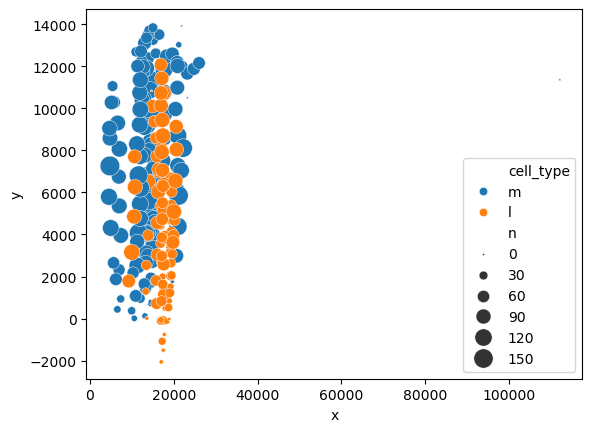

In [376]:
ax = sns.scatterplot(data=df,x='x',y='y',size='n',hue='cell_type',sizes=(2, 200),legend=True)
# ax.set_aspect('equal', adjustable='datalim')
# ax.set_ylim(0,300)
# ax.set_xlim(0,500)
# for y_ in [2365*16, 4344*16, 8432*16, 11138*16, 13021*16, 15045*16, 15700*16]:
#     ax.axhline(y=y_/1000,color = 'black',linestyle='--')
# ax.invert_yaxis()


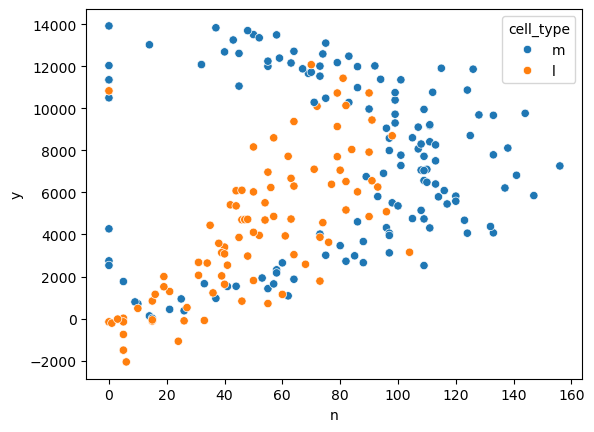

In [377]:
ax = sns.scatterplot(data=df,x='n',y='y',hue='cell_type',legend=True)

In [428]:
# Define depth bins and labels
bins = [1000, 3000, 5000, 7000, 9000, 12000,14000]
labels = ['d0', 'd1', 'd2', 'd3', 'd4','d5']

# Create a new column for the depth bin based on 'y'
df['depth_bin'] = pd.cut(df['y'], bins=bins, labels=labels, right=False)

# Calculate the mean 'n' for each depth bin
mean_n_per_bin = df.groupby(['depth_bin','cell_type'], observed=False)['n'].mean()

In [429]:
df

,id,cell_type,x,y,z,n,depth_bin
0,128737253,m,14425.0,702.0,641.0,10,NaN
1,128737253,m,14518.0,790.0,594.0,9,NaN
2,128737253,m,14592.0,1658.0,691.0,33,d0
3,128737253,m,14860.0,3470.0,477.0,80,d1
4,128737253,m,14761.0,5150.0,713.0,108,d2
...,...,...,...,...,...,...,...
229,472392041,l,19820.0,3630.0,3002.0,76,d1
230,472392041,l,20034.0,5085.0,3156.0,96,d2
231,472392041,l,20415.0,6559.0,3108.0,91,d2
232,472392041,l,20641.0,8046.0,2885.0,84,d3


<Axes: xlabel='depth_bin', ylabel='n'>

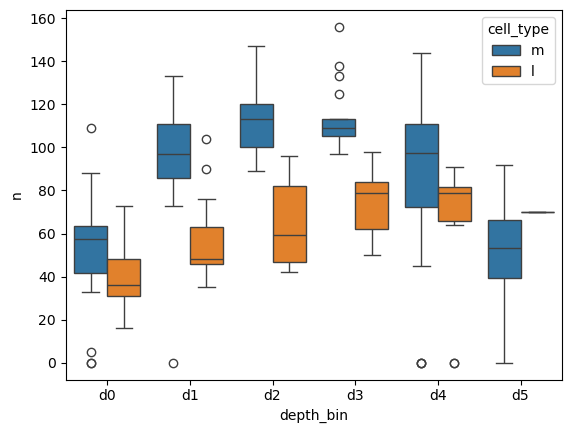

In [430]:
sns.boxplot(data = df,x = 'depth_bin', y = 'n',hue='cell_type')

In [386]:
df = pd.DataFrame(mean_n_per_bin).reset_index().rename(columns={'depth_bin':'label'})#(names='label')

### total branch length estimates

In [433]:
jsondir = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/Spine_Density_Annotation/dend_length')
flist = ['299496636_mg1.json','214581797_mg2.json','301787806_lg.json','393325331_lf.json'] #

df_summary = pd.DataFrame(columns=['label','length','cell_type'])

for fname in flist:
    row_dict = {}
    with open(jsondir / fname, 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
        json_data = json.load(myfile)


    data = {}
    dlist = ['d0','d1','d2','d3','d4','d5','d6']
    llist = [2000,2000,2000,2000,2000,2000,2000]
    for i,d in enumerate(dlist[:-1]):
        d1 = len(next((item for item in json_data['layers'] if item["name"] == dlist[i]), None)['annotations'])
        d2 = len(next((item for item in json_data['layers'] if item["name"] == dlist[i+1]), None)['annotations'])
        # print(d1,d2)
        row_dict={
            'label' : [d],
            'length' : [np.mean([d1,d2]) * llist[i] * 16 /1000], # total length in bin = number branches times llist[i] voxels long, 16nm per voxel, 1micron per 1000 nm
            'cell_type' : [fname.split('_')[1].split('.')[0][0]],
            'id' : [fname.split('_')[0]]
        }

        df_summary = pd.concat([df_summary,pd.DataFrame.from_dict(row_dict,orient = 'columns')])
    # df_summary = pd.concat([df_summary,pd.DataFrame.from_dict(data,orient='index').reset_index(names = 'label').rename(columns={0:'length'})],
    #          ignore_index=True)

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_1214/2596363521.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_summary = pd.concat([df_summary,pd.DataFrame.from_dict(row_dict,orient = 'columns')])


<Axes: xlabel='label', ylabel='length'>

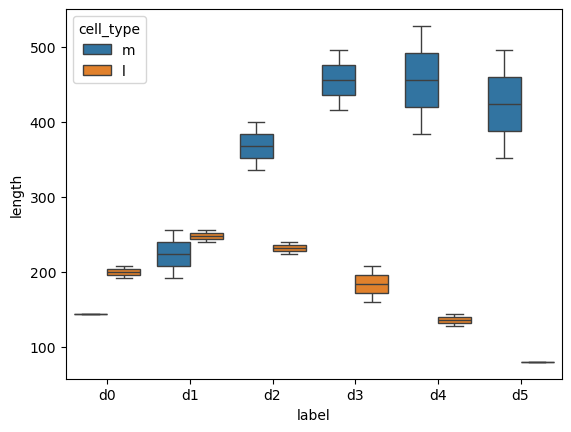

In [435]:
df_summary
sns.boxplot(data = df_summary,x = 'label', y = 'length',hue='cell_type')

In [395]:
mean_l_per_bin = df_summary.groupby(['label','cell_type'], observed=False)['length'].mean()

In [396]:
df_summary = pd.DataFrame(mean_l_per_bin).reset_index()#(names='label')

In [397]:
df_summary

,label,cell_type,length
0,d0,l,200.0
1,d0,m,144.0
2,d1,l,248.0
3,d1,m,224.0
4,d2,l,232.0
5,d2,m,368.0
6,d3,l,184.0
7,d3,m,456.0
8,d4,l,136.0
9,d4,m,456.0


## merge dataframes

In [399]:
df_summary = pd.merge(df, df_summary, on=['label','cell_type'])

In [401]:
df_summary


,label,cell_type,n,length
0,d0,l,38.647059,200.0
1,d0,m,53.000000,144.0
2,d1,l,55.360000,248.0
3,d1,m,95.647059,224.0
4,d2,l,64.944444,232.0
5,d2,m,113.352941,368.0
6,d3,l,74.555556,184.0
7,d3,m,113.388889,456.0
8,d4,l,63.800000,136.0
9,d4,m,88.187500,456.0


## calculate spine count per bin and sum for total

In [402]:
for i,r in df_summary.iterrows():
    df_summary.loc[i,'total']=(r['n']/10)*r['length']

In [403]:
df_summary

,label,cell_type,n,length,total
0,d0,l,38.647059,200.0,772.941176
1,d0,m,53.000000,144.0,763.200000
2,d1,l,55.360000,248.0,1372.928000
3,d1,m,95.647059,224.0,2142.494118
4,d2,l,64.944444,232.0,1506.711111
5,d2,m,113.352941,368.0,4171.388235
6,d3,l,74.555556,184.0,1371.822222
7,d3,m,113.388889,456.0,5170.533333
8,d4,l,63.800000,136.0,867.680000
9,d4,m,88.187500,456.0,4021.350000


In [405]:
df_summary.groupby(['cell_type'])['total'].sum()

cell_type
l     6452.08251
m    18429.59902
Name: total, dtype: float64

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_1214/2694191851.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  h.set_xticklabels(np.asarray([3000,5000,7000,9000,11000,13000])*16/1000);


Text(0, 0.5, 'spines per depth bin')

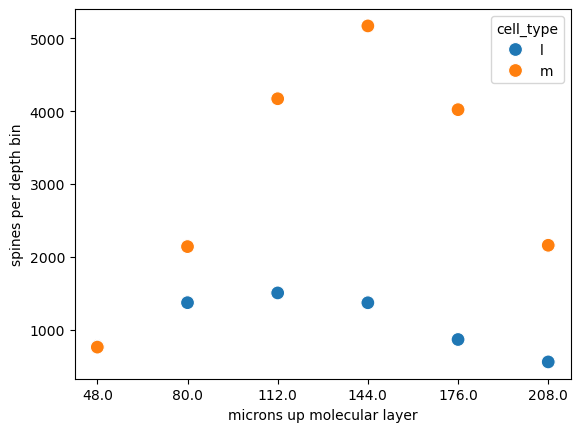

In [432]:
h = sns.scatterplot(data = df_summary,x = 'label', y = 'total',hue='cell_type',s=100)
# ax = h.gca()
h.set_xticklabels(np.asarray([3000,5000,7000,9000,11000,13000])*16/1000);
h.set_xlabel('microns up molecular layer')
h.set_ylabel('spines per depth bin')

In [410]:
h

<Axes: xlabel='label', ylabel='total'>

# OTHER

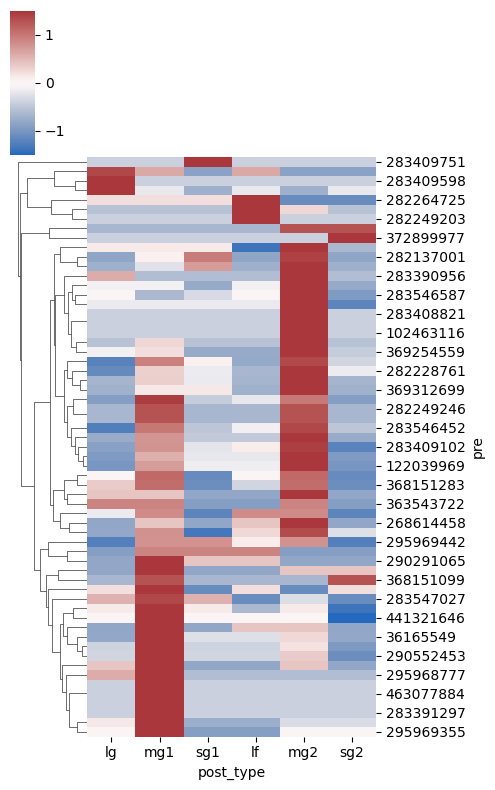

In [180]:

# sns.set(font_scale=1.4)
sns.clustermap(data=df_map,z_score=0,cmap='vlag',col_cluster=False, vmin=-1.5, vmax=1.5,figsize=(5,8))

In [181]:
df_map[(df_map['lg'] != 0)& (df_map['lf'] != 0)]

post_type,lg,mg1,sg1,lf,mg2,sg2
pre,,,,,,
27220895,1.0,2.0,0.0,2.0,2.0,0.0
187151336,4.0,8.0,4.0,2.0,4.0,0.0
187230424,1.0,3.0,2.0,1.0,6.0,1.0
188296613,3.0,2.0,0.0,2.0,0.0,0.0
273086215,1.0,6.0,2.0,2.0,9.0,1.0
282264725,1.0,1.0,1.0,2.0,0.0,0.0
283408822,1.0,5.0,1.0,1.0,2.0,0.0
283409058,1.0,2.0,0.0,1.0,2.0,0.0
283409102,2.0,7.0,4.0,5.0,9.0,1.0


<Axes: xlabel='lf', ylabel='mg1'>

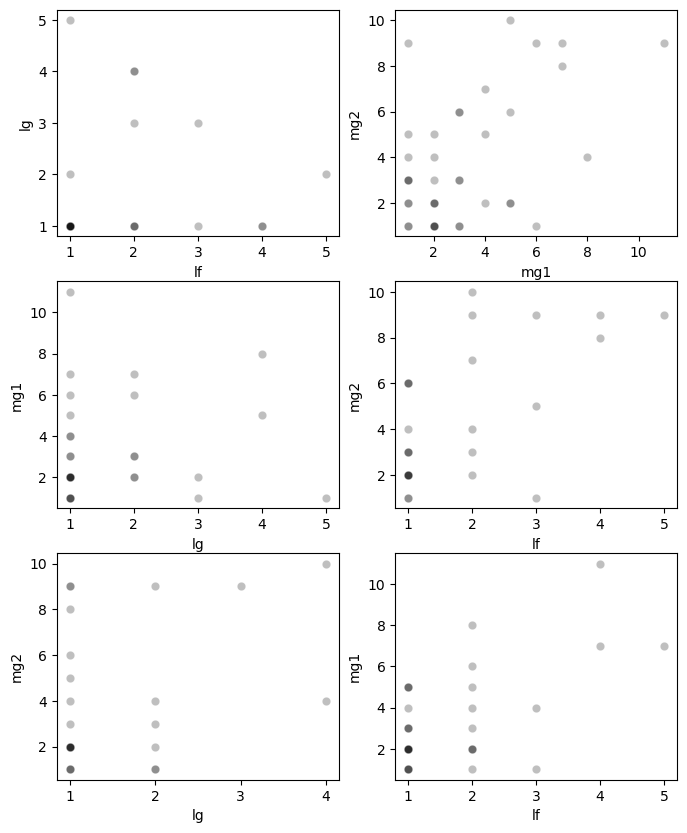

In [182]:
hfig,ax = plt.subplots(3,2,figsize=(8,10))
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['lf'] != 0)], x = 'lf', y = 'lg', ax = ax[0][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['mg1'] != 0)& (df_map['mg2'] != 0)], x = 'mg1', y = 'mg2', ax = ax[0][1],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['mg1'] != 0)], x = 'lg', y = 'mg1', ax = ax[1][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lf'] != 0)& (df_map['mg2'] != 0)], x = 'lf', y = 'mg2', ax = ax[1][1],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['mg2'] != 0)], x = 'lg', y = 'mg2', ax = ax[2][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lf'] != 0)& (df_map['mg1'] != 0)], x = 'lf', y = 'mg1', ax = ax[2][1],alpha = 0.25,color = 'black')